
## Install and Import Modules
#### Install 
Add more if needed. I have provided some installation commands but you may need more if you do not have them installed yet.

In [ ]:
%%capture
# %%capture is used to ignore output when content is boring.
# This is how you install modules from jupyter notebook instead of terminal. 
# Install the one you need or comment them out 
!pip3 install -U imageio-ffmpeg         #It contains VideoFileClip module needed in the next cell. 
!pip3 install ipywidgets                #It contains ipywidget module
!pip install opencv-contrib-python      #It contains opencv module from https://www.pyimagesearch.com/2018/09/19/pip-install-opencv/
!jupyter nbextension enable --py widgetsnbextension

#### Import
if errors then you may need to go back and install it first.

In [1]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import ipywidgets as ipw
import os
import random
from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML, YouTubeVideo, display
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

## Watch Input <font color="violet"> Video </font>

Run the sample video I have provided first along with the whole tutorial, then

Try your own video:
- Place your video in the `Input_Video` folder
- Change <b>ONLY</b> the `video_name` in the cell below. 

In [2]:
video_name = "sample.mp4"
input_video_path = os.path.join("Input_Video", video_name)

#Erase this!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_rotated." + video_name_part[1])
input_video_path = dest_path

# Watch Video
display(HTML("""
            <video width="960" height="540" controls>
              <source src="{0}">
            </video>
            """.format(input_video_path)))

## Needs Rotation?
I recorded my video with my phone in horizontal position. So I need to rotate it. Run the cells below if you also need rotation. Otherwise skip this section and go to next section: `Visualize and Explore video`

In [ ]:
def rotateImage(image, angle):
    """"
    Performs a counter clockwise rotation of the angle specified. Set Angle to 90 to rotate left or -90 for right  
    """

    (h, w) = image.shape[:2]        # get image height, width
    cx, cy = int(w/2), int(h/2)     # calculate the center of the original image    

    # Translate image center to the right before rotation
    tx = cy-cx     #translate in x
    ty = 0         #translate in y
    M  = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image, M, (h,h))       # make square image (hxh)

    # Perform the counter clockwise rotation holding at the center
    center = (cy, cy)               # calculate new center of square image
    scale  = 1.0                    # keep same dimension in image
    M = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine(image, M, (h, h))

    # Translate image center to the top and crop bottom
    tx = 0          #translate in x
    ty = cx-cy      #translate in y
    M  = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image, M, (h,w))       # this crops bottom as well

    return image

Let's implement it on the first frame of the video to make sure everything looks okay. Set `angle` to 90 to rotate left or -90 for right

In [ ]:
# Load video and Read frame
cap = cv2.VideoCapture(input_video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #First frame
_, frame = cap.read() 

# Rotate to left
angle = 90
frame_rotated = rotateImage(frame , angle)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame_rotated = cv2.cvtColor(frame_rotated,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(11, 5))   #width, height in inches
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(frame)

plt.subplot(1,2,2)
plt.title("Rotated")
plt.imshow(frame_rotated)

It works! So let's implemented in the whole video and place it in the `Output_Video` folder which we will create. Again set `angle` to 90 to rotate left or -90 for right

In [ ]:
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")
    
# Rotate video
angle = 90
clip  = VideoFileClip(input_video_path)
video_clip = clip.fl_image(lambda image: rotateImage(image, angle))

# Save rotated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_rotated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

Let's watch it now! And reassign the input video path to our new rotated video!

In [ ]:
# Reassign Input path to rotated video
input_video_path = dest_path

# Watch Video                                  
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

## Enumerate Frames of Video
We want need to enumerate the frames of our video to know what frames will be with the "lights OFF". Run the cells below to know which frame intervals will remain in the "dark". 

In [3]:
def addFrameNumber(image, frame_num, frame_count, font_scale, color, thickness):
    
    # Add frame number
    (h, w) = image.shape[:2]                                                  # get image height, width
    box_startX, box_startY, box_endX, box_endY = 0, 0, int(0.5*w), int(0.2*h) # Box vertices follows golden ratio 
    image[box_startY: box_endY, box_startX:box_endX] = 0                      # Black rectangle in left corner 
    text = "Frame: "+ str(frame_num) + "/" + str(frame_count)
    text_startX, text_startY = 0, box_endY- int(box_endY*0.4)
    cv2.putText(image, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)
    
    return frame

Let's first enumerate a random frame from our video to make sure everything looks ok. Set `font_scale`, `color`, and `thickness` to your taste to suit your video.

Frames Per Sec FPS = 30.0
Number of Frames   = 1662
Duration [Sec]     = 55
Duration [Min:Sec] = 0:55


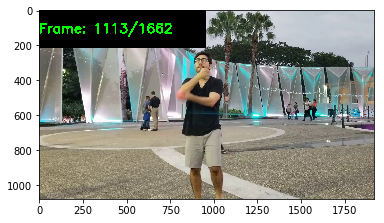

In [4]:
# Load video
cap = cv2.VideoCapture(input_video_path)

# Get General Info
fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(frame_count/fps)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float

# Read frame
frame_num = random.randint(0,frame_count)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Add frame number
font_scale, color, thickness= 2.5, (0, 255, 0), 10
frame = addFrameNumber(frame, frame_num, frame_count, font_scale, color, thickness)

# Display
print('Frames Per Sec FPS = ' + str(fps))
print('Number of Frames   = ' + str(frame_count))
print('Duration [Sec]     = ' + str(duration))
minutes = int(duration/60)
seconds = duration%60
print('Duration [Min:Sec] = ' + str(minutes) + ':' + str(seconds))
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

It works! So let's implement it in the whole video and place it in the Output_Video folder which we will create. <b>This may take a while...</b> 

In [5]:
# Create folder to place processed images at same level directory as input folder
try: 
    images_path = os.path.join("Output_Video", "Enumerated_Images")
    os.mkdir(images_path)
except FileExistsError:
    print ("Output Folder is ready already")

# Add frame number to each image and save them
for frame_num in range(frame_count):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    _,frame=cap.read()
    frame = addFrameNumber(frame, frame_num, frame_count, font_scale, color, thickness)
    image_path =  os.path.join(images_path, "Frame_" + str(frame_num)+".jpg")
    cv2.imwrite(image_path, frame)   

Collect the saved images to create video!

In [6]:
IMAGE_EXT = ['jpeg', 'gif', 'png', 'jpg']

# Convert file folder into list filtered for image file types
image_list = sorted(os.listdir(images_path), key=lambda a: int((a.split(".")[0]).split("_")[1]))
image_list = [os.path.join(images_path, image_file) for image_file in image_list]
image_list = [image_file for image_file in image_list if os.path.splitext(image_file)[1][1:].lower() in IMAGE_EXT]

# Make video
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
clip = ImageSequenceClip(image_list, fps=fps)
clip.write_videofile(dest_path)

# Delete folder of enumerated images
try: 
    shutil.rmtree(images_path)
except FileNotFoundError:
    print ("Folder has been deleted already and Video is ready")   

[MoviePy] >>>> Building video Output_Video/sample_enumerated.mp4
[MoviePy] Writing video Output_Video/sample_enumerated.mp4


100%|██████████| 1662/1662 [04:52<00:00,  4.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_Video/sample_enumerated.mp4 



Let's watch it now! Take note of the frame intervals you want to turn OFF the lights.

In [7]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

## Turn OFF The Lights

From the previous video we know now that frames [93,184] , [465,1458], and [1588,1662] must be in the "dark." Let's explore on a random frame from our video all our binary options. 

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()

def browse_images(digits):
    n = len(digits.images)
    def view_image(i):
        plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Training: %s' % digits.target[i])
        plt.show()
    ipw.interact(view_image, i=(0,n-1))

browse_images(digits)

In [ ]:

cap = cv2.VideoCapture(input_video_path)
# cap.set(cv2.CAP_PROP_POS_FRAMES, 1009)
# _,frame=cap.read()
# frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
# plt.imshow(frame)
# plt.show()

def browse_images(cap):
    n = frame_count#int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    def view_image(i):
        
        cap = cv2.VideoCapture(input_video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        _,frame=cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.show()
    ipw.interact(view_image, i=(0,n-1))

browse_images(cap)

In [ ]:
# Youtube Video explaining about widgets
#display (YouTubeVideo('eWzY2nGfkXk'))

# Widgets
right_btn  = ipw.Button( button_style='info', icon='fa-arrow-right' )
left_btn   = ipw.Button( button_style='info', icon='fa-arrow-left') # 'fa-step-forward'
slider     = ipw.IntSlider(value=0, min=0, max=frame_count-1, description='FRAME:', continuous_update=True)
title      = ipw.HTML("<h3 class='text-left'><font color='green'> My Media Player</font> in <font color='blue'> Frames</font></h3>")
play       = ipw.Play(interval=10, min=0, max=frame_count-1, description="Press play")
video_out  = ipw.Output(layout={'border': '1px solid black'})
#print(video_out.keys) # Check all input arguments

# Linkers
play_slider_link = ipw.jslink((play, 'value'), (slider, 'value'))


# out.append_stdout('Output appended with append_stdout')
# out.append_display_data(YouTubeVideo('eWzY2nGfkXk'))
#     |

#Callback functions
plt.figure(figsize=(20, 20))   #width, height in inches
def right_btn_callback(change):
    slider.value = min(slider.value+1,slider.max)
def left_btn_callback(change):
    slider.value = max(slider.value-1,slider.min)
def play_callback(change):
    slider.value = play.value
def slider_callback(change):
    video_out.clear_output()
    cap.set(cv2.CAP_PROP_POS_FRAMES, slider.value)
    _,frame=cap.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    with video_out:
        plt.xticks([])
        plt.yticks([])
        plt.imshow(frame)
        display(plt.show())
#     with video_out:
#         display(plt.imshow(frame))
#     video_out.append_display_data(frame)

# Triggers        
right_btn.on_click(right_btn_callback)
left_btn.on_click(left_btn_callback)
slider.observe(slider_callback, 'value')
play.observe(play_callback, 'value')

#Display
media_player = ipw.VBox([title, video_out, ipw.HBox([play, left_btn, slider, right_btn])])
display(media_player)


Use this to discover what frame numbers we need to set the beginnings and ends of when we turn OFF the lights in the video.

- [Widget List](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#Button)
- [Widget_Tutorial](https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916)

In [ ]:
def DisplayFrame():
    # Read frame
    _,frame=cap.read(0)
    
    # Display
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(11, 5))   #width, height in inches
    plt.title("Original")
    plt.imshow(frame)

right.on_click(DisplayFrame)

<b> Play the video inline by running the following cell, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.
</b>

In [ ]:
# When everything done, release the capture
cap.release()